# Chapter 3: Mapping Sea Ice Concentration

* **Creators:** Ann Windnagel and Robyn Marowitz
* **Affiliation:** [National Snow and Ice Data Center (NSIDC)](https://nsidc.org/home "National Snow and Ice Data Center")
* **History:**
  * January 2025 - Initial version

## Overview

In this notebook, you will learn how to create a map of sea ice concentration for one day of data using STAC, Xarrary, and the matplotlib package. The dates you will plot are the record sea ice minimum for both hemispheres which were 21 February 2023 for the Southern Hemisphere and 17 September 2012 for the Northern Hemisphere.

### Prerequisites
Read and understand the material in Notebook 2.

### Targeted Level
Beginner/Intermediate

### Learning Outcomes
Once you have completed this notebook, you will be able to:
* Extract sea ice concentration from a SIC CDR netCDF file for one day of data and threshold the concentration to 15%
* Extract the land surface masks from the sea ice data for plotting
* Plot the sea ice concentration and the land surfaces using different colormaps for the record sea ice minimum for both hemispheres

### Time Estimate
TBD

### Import Relevant Packages
You will use [Matplotlib](https://matplotlib.org/ "Matplotlib web site") to plot the data.

In [1]:
from datetime import datetime, date, timedelta
import xarray as xr
import numpy as np
import numpy.ma as ma
import fsspec
import pystac
import matplotlib.pyplot as plt

************************
## Tutorial

Plot sea ice concentration data
*************************

###  Read the STAC Collection and NetCDF Files
To begin, you will repeat some code from Notebook 2 to access the STAC *Item* and the read the appropriate netCDF file. You will again be working with the 2023 daily Southern Hemisphere data.

In [2]:
# Specify the URL to the sea ice CDR collection.json file on NSIDC servers
collection_url = 'https://noaadata.apps.nsidc.org/NOAA/G02202_V4/stac/collection.json'
# Read file and assign to a variable
collection = pystac.Collection.from_file(collection_url)

# Extract items from the collection
items = list(collection.get_all_items())

# Extract all the Item IDs from the item list
item_ids = [i.id for i in items]

# Find the item id for the 2023 daily SH file
# This command returns a list with one element that contains the id you want
daily_sh_2023_id = [i for i in item_ids if "daily_sh_2023" in i]

# Get item using item id
daily_sh_2023_item = collection.get_item(daily_sh_2023_id[0], recursive=True)

# Get the URL from the STAC Item assets
netcdf_url_2023 = daily_sh_2023_item.assets['netcdf'].href

# Read the netCDF file at that URL using fsspec and xarray and print out the result
fs_2023 = fsspec.filesystem('https')
ds_2023 = xr.open_dataset(fs_2023.open(netcdf_url_2023))

### Extract the Sea Ice Concentration Data

In [3]:
# Pull out sea ice concentration variable and then put the data into a numpy array
cdr_seaice_conc_2023 = ds_2023.variables['cdr_seaice_conc']
cdr_seaice_conc_2023_np = np.array(cdr_seaice_conc_2023.data)

### Create a Map using the Sea Ice Concentration Data
Above you read in the Sea Ice Concentration data from `cdr_seaice_conc` variable in the netCDF file. Now you will create a map of one day of SIC data. To do this, you will do the following steps:
* Pull out one day of data from Xarray dataset object and put into a numpy array
* Threshold the sea ice concentration to 15%
* Create filters for the surface types (ocean, land, coast, lake)
* Plot the SIC and surface types on one map

#### Extract One Day of Data

In the previous code cells, you read in the 2023 data for the Southern Hemisphere. In the next cell, you will pull out the data for the record sea ice minimum for the Southern Hemisphere which occurred on 21 February 2023. As noted in Notebook 1, in the Southern Hemisphere, the sea ice minimum occurs in February or March every year, and in 2023 it was the lowest it had ever been.

In [4]:
# Extract time out of the Xarray dataset object and put into a numpy array
time_2023 = ds_2023.variables['time']
time_2023_np = np.array(time_2023.data)
# Find index where 21 February 2023 occurs
sh_index = np.where(time_2023_np == np.datetime64(datetime(2023, 2, 21)))

# Pull out the data for 21 February 2023 and put it in a numpy array
seaice_conc_feb2023 = np.squeeze(cdr_seaice_conc_2023_np[sh_index[0],:,:])

#### Threshold the Concentration to 15%

As noted in Notebook 1, a common threshold for sea ice concentrations is 15%. You will apply this 15% threshold to the SIC CDR data before plotting it.

In [5]:
# Set all concentrations less than 15 to ocean (0)
is_not_seaice = seaice_conc_feb2023 < .15
seaice_conc_feb2023[is_not_seaice] = 0

# Only keep sea ice conentration i.e. where ice is between 15 and 100% and remove the surface masks and missing values
sic_15_feb2023 = ma.masked_outside(seaice_conc_feb2023, .15, 1)

#### Mask Out Surface Types
The `cdr_seaice_conc` variable in the netCDF files contains flags for different land surface types. You will create masks for each so that you can plot them with the sea ice concentration. Note that you will need to look at the flag values for the variable to get the correct values. You learned how to do this in Notebook 2 with the `cdr_seaice_conc_2023.attrs` command. This command is in the cell below. Once you run this command, you will see two attributes that describe the flags and their values: `flag_values` and `flag_meanings`. There are five flags with the following values: 
1. pole hole: 251
2. lakes: 252
3. coast: 253
4. land: 254
5. missing data: 255

In [6]:
cdr_seaice_conc_2023.attrs

{'long_name': 'NOAA/NSIDC Climate Data Record of Passive Microwave Daily Southern Hemisphere Sea Ice Concentration',
 'standard_name': 'sea_ice_area_fraction',
 'units': '1',
 'flag_values': array([251, 252, 253, 254, 255], dtype=uint8),
 'flag_meanings': 'pole_hole lakes coastal land_mask missing_data',
 'datum': '+ellps=urn:ogc:def:crs:EPSG::4326',
 'grid_mapping': 'projection',
 'reference': 'https://nsidc.org/data/g02202/versions/4/',
 'ancillary_variables': 'stdev_of_cdr_seaice_conc qa_of_cdr_seaice_conc',
 'valid_range': array([  0, 100], dtype=uint8),
 'cell_methods': 'tdim: mean'}

<div class="alert alert-block alert-info">
<strong>Note:</strong> You'll see in the cell below that you will mask out values of 2.52, 2.53, and 2.54. You are not using the numbers 252, 253, and 254, as is listed in the attributes above, because the netCDF files contain an attribute for a scale factor on the data of .01. It is not listed in the attributes above because Xarray automatically applies the scale factor to the data.
</div>

In [7]:
# Filter out the ocean where pixels = 0
ocean = ma.masked_outside(seaice_conc_feb2023, 0, 0)

# Filter out the surface values (land, coast, lake)
land = ma.masked_outside(seaice_conc_feb2023, 2.54, 2.54)
coast = ma.masked_outside(seaice_conc_feb2023, 2.53, 2.53)
lakes = ma.masked_outside(seaice_conc_feb2023, 2.52, 2.52)

<div class="alert alert-block alert-success">
<h3><strong>Check Your Work</strong></h3>
You can verify that the image you created below is create by checking it against another sea ice data set called the Sea Ice Index: <a href="https://noaadata.apps.nsidc.org/NOAA/G02135/south/daily/images/2023/02_Feb/S_20230221_conc_hires_v3.0.png">https://noaadata.apps.nsidc.org/NOAA/G02135/south/daily/images/2023/02_Feb/S_20230221_conc_hires_v3.0.png</a>.</br>
The two images won't look exactly the same, since they are different data sets using different sea ice algorithms; but they should look similar.
</div>

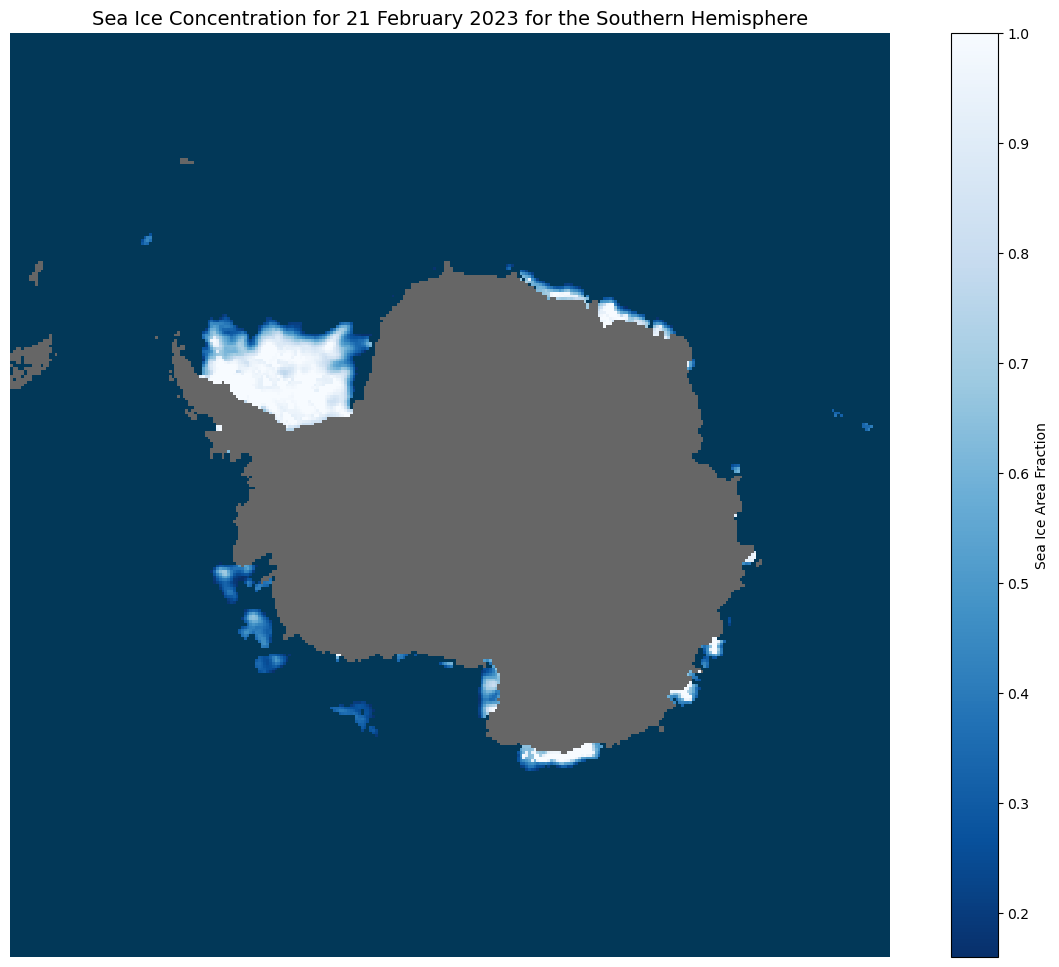

In [42]:
# Plot the map using different color maps for the sea ice, land/coast, and ocean/lake
# Set up plot space
fig, ax1 = plt.subplots(figsize=(16, 12))

# Plot 15% sesa ice concentration
seaice_15_plot = ax1.imshow(sic_15_feb2023, cmap='Blues_r', interpolation='none')

# Add a colorbar
cbar = fig.colorbar(seaice_15_plot, ax=ax1)
# Add a title to the colorbar
cbar.set_label('Sea Ice Area Fraction')

# Plot land surfaces
land_plot = ax1.imshow(land, cmap='Accent_r', interpolation='none')
coast_plot = ax1.imshow(coast, cmap='Accent_r', interpolation='none')
ocean_plot = ax1.imshow(ocean, cmap='PuBu_r', interpolation='none')
lake_plot = ax1.imshow(lakes, cmap='PuBu_r', interpolation='none')

# Plot title and turn off axes
plt.title("Sea Ice Concentration for 21 February 2023 for the Southern Hemisphere", fontsize=14)
plt.axis('off')
plt.show()

<div class="alert alert-block alert-success">
<h3><strong>Exercise</strong></h3>
Using the example from this Tutorial, uncomment the template below, and change the code as necessary to plot the sea ice concentration minimum for the Northern Hemisphere on 17 September 2012. <strong>Be sure to update variable names and map titles as appropriate as well.</strong>
</div>

<div class="alert alert-block alert-info">
<strong>Hint:</strong> Think about what you need to search for to find the correct `Item id` for the daily 2012 Northern Hemisphere <em>Item</em>.
</div>

#### Get the 2012 Northern Hemisphere Data

In [ ]:
# Find the item id for the 2012 daily NH file
#daily_sh_2023_id = [i for i in item_ids if "daily_sh_2023" in i] # Uncomment out this command and update as necessary

# Get item using item id
#daily_sh_2023_item = collection.get_item(daily_sh_2023_id[0], recursive=True) # Uncomment out this command and update as necessary

# Get the URL from the STAC Item assets
#netcdf_url_2023 = daily_sh_2023_item.assets['netcdf'].href # Uncomment out this command and update as necessary

# Read the netCDF file at that URL using fsspec and xarray and print out the result
#fs_2023 = fsspec.filesystem('https') # Uncomment out this command and update as necessary
#ds_2023 = xr.open_dataset(fs_2023.open(netcdf_url_2023)) # Uncomment out this command and update as necessary

#### Extract the Sea Ice Concentration Variable from the 2012 File

In [ ]:
# Pull out sea ice concentration variable and then put the data into a numpy array
#cdr_seaice_conc_2023 = ds_2023.variables['cdr_seaice_conc'] # Uncomment out this command and update as necessary
#cdr_seaice_conc_2023_np = np.array(cdr_seaice_conc_2023.data) # Uncomment out this command and update as necessary

#### Get the Time Variable and Pull out the Data for 17 September 2012

In [ ]:
# Extract time out of the Xarray dataset object and put into a numpy array
#time_2023 = ds_2023.variables['time'] # Uncomment out this command and update as necessary
#time_2023_np = np.array(time_2023.data) # Uncomment out this command and update as necessary

# Find index where 21 February 2023 occurs
#sh_index = np.where(time_2023_np == np.datetime64(datetime(2023, 2, 21))) # Uncomment out this command and update the date

# Pull out the data for 21 February 2023 and put it in a numpy array
#seaice_conc_feb2023 = np.squeeze(cdr_seaice_conc_2023_np[sh_index[0],:,:]) # Uncomment out this command and update as necessary

#### Threshold the Concentration to 15%

In [ ]:
# Set all concentrations less than 15 to ocean (0)
#is_not_seaice = seaice_conc_feb2023 < .15 # Uncomment out this command and update as necessary
#seaice_conc_feb2023[is_not_seaice] = 0 # Uncomment out this command and update as necessary

# Only keep sea ice conentration i.e. where ice is between 15 and 100% and remove the surface masks and missing values
#sic_15_feb2023 = ma.masked_outside(seaice_conc_feb2023, .15, 1) # Uncomment out this command and update as necessary

#### Mask Out Surface Types

In [ ]:
# Filter out the ocean where pixels = 0
#ocean = ma.masked_outside(seaice_conc_feb2023, 0, 0) # Uncomment out this command and update as necessary

# Filter out the surface values (land, coast, lake)
#land = ma.masked_outside(seaice_conc_feb2023, 2.54, 2.54) # Uncomment out this command and update as necessary
#coast = ma.masked_outside(seaice_conc_feb2023, 2.53, 2.53) # Uncomment out this command and update as necessary
#lakes = ma.masked_outside(seaice_conc_feb2023, 2.52, 2.52) # Uncomment out this command and update as necessary

#### Plot the Northern Hemisphere Record Minimum

<div class="alert alert-block alert-success">
<h3><strong>Check Your Work</strong></h3>
You can verify that the image you created below is create by checking it against another sea ice data set called the Sea Ice Index: <a href="https://noaadata.apps.nsidc.org/NOAA/G02135/north/daily/images/2012/09_Sep/N_20120917_conc_hires_v3.0.png">https://noaadata.apps.nsidc.org/NOAA/G02135/north/daily/images/2012/09_Sep/N_20120917_conc_hires_v3.0.png</a>.</br>
The two images won't look exactly the same, since they are different data sets using different sea ice algorithms; but they should look similar.
</div>

In [ ]:
# Plot the map using different color maps for the sea ice, land/coast, and ocean/lake
# Set up plot space
#fig, ax1 = plt.subplots(figsize=(16, 12)) # Uncomment out this command and update as necessary

# Plot 15% sesa ice concentration
#seaice_15_plot = ax1.imshow(sic_15_feb2023, cmap='Blues_r', interpolation='none') # Uncomment out this command and update as necessary

# Add a colorbar
#cbar = fig.colorbar(seaice_15_plot, ax=ax1) # Uncomment out this command
# Add a title to the colorbar
#cbar.set_label('Sea Ice Area Fraction') # Uncomment out this command

# Plot land surfaces
#land_plot = ax1.imshow(land, cmap='Accent_r', interpolation='none') # Uncomment out this command
#coast_plot = ax1.imshow(coast, cmap='Accent_r', interpolation='none') # Uncomment out this command
#ocean_plot = ax1.imshow(ocean, cmap='PuBu_r', interpolation='none') # Uncomment out this command
#lake_plot = ax1.imshow(lakes, cmap='PuBu_r', interpolation='none') # Uncomment out this command

# Plot title and turn off axes
#plt.title("Sea Ice Concentration for 21 February 2023 for the Southern Hemisphere", fontsize=14) # Uncomment out this command and update title date
#plt.axis('off') # Uncomment out this command and update as necessary
#plt.show() # Uncomment out this command and update as necessary

### Next Steps

After successful completion of Notebook 3, you can go on to Notebook 4: Computing Sea Ice Extent and Plotting a Time Series Graph.

### Data Statement

Meier, W. N., Fetterer, F., Windnagel, A. K., & Stewart, J. S. (2021). NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration. (G02202, Version 4). [Data Set]. Boulder, Colorado USA. National Snow and Ice Data Center. https://doi.org/10.7265/efmz-2t65.

### Metadata

* Language/Package(s)
  * Python
  * xarray
  * pystac
  * numpy
  * matplotlib
* Geophysical Keywords
  * Sea Ice Concentration

### Software License

Copyright 2025 NOAA NCAI

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

### Content License

[CC BY 4.0](https://creativecommons.org/licenses/by/4.0/ "Createive Commons BY 4.0 License")

### Disclaimer

This Jupyter notebook is a scientific product and is not official communication of the National Oceanic and Atmospheric Administration, or the United States Department of Commerce. All NOAA Jupyter notebooks are provided on an 'as is' basis and the user assumes responsibility for its use. Any claims against the Department of Commerce or Department of Commerce bureaus stemming from the use of this Jupyter notebook will be governed by all applicable Federal law. Any reference to specific commercial products, processes, or services by service mark, trademark, manufacturer, or otherwise does not constitute or imply their endorsement, recommendation or favoring by the Department of Commerce. The Department of Commerce seal and logo, or the seal and logo of a DOC bureau, shall not be used in any manner to imply endorsement of any commercial product or activity by DOC or the United States Government.